# How Many Journals Are There? Centering the Discounted 
Jon Ball, Saurabh Khanna, and John Willinsky

## Table of Contents
1. [Introduction](#introduction)
2. [Data Preprocessing](#dataprep)
3. [Journals using OJS](#activeojs)
    1. [Active journals](#growth)
    2. [Languages](#languages)
    3. [Disciplines](#disciplines)
4. [World Bank income groups](#worldbank)
5. [Index Overlap](#index)

## Introduction <a name="introduction"></a>

## Data Preprocessing <a name="dataprep"></a>
Import packages and read the beacon dataset into pandas:

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import re

beacon = pd.read_csv('data/beacon.csv')

Slice the beacon DataFrame so that it includes only **active journals (publishing 5 or more articles per year)**:

In [2]:
beaconActive = beacon[beacon['record_count_2020'] >= 5].reset_index(drop=True)

Select only columns relevant to the analysis:

In [3]:
beaconActive = beaconActive[['oai_url', 
                             'set_spec',
                             'context_name',
                             'issn',
                             'country_consolidated']]

Clean the 'oai_url' variable:

In [4]:
#Several 'oai_url' vars contain duplicates and trailing punctuation
beaconActive['oai_url'] = beaconActive['oai_url'].str.split(r'\s|\?').str.get(0).str.replace('[\./]+$', '', regex=True)

Clean the 'issn' variable:

In [5]:
#Several issn vars contain two issns separated by '\n'
beaconActive['issn_1'] = beaconActive['issn'].str.split(r'\n').str.get(0)
beaconActive['issn_2'] = beaconActive['issn'].str.split(r'\n').str.get(1)

Create a new 'journal_url' column for accessing journal web pages:

In [6]:
pattern = re.compile("index/oai$|oai$")

def create_url(row):
    return pattern.sub("", row["oai_url"]) + row["set_spec"]

beaconActive['journal_url'] = beaconActive.apply(create_url, axis=1)

Check for missing values and duplicates:

In [7]:
beaconActive.isnull().sum()

oai_url                     0
set_spec                    0
context_name                0
issn                     2910
country_consolidated       94
issn_1                   2910
issn_2                  17323
journal_url                 0
dtype: int64

In [8]:
beaconActive.duplicated().any()

False

## Journals using OJS <a name=activeojs></a>

### Growing number of active journals, articles published using OJS (2010-2020) <a name=growth></a>

In [9]:
#Drop duplicate journal titles from the beacon DataFrame
beacon.drop_duplicates(subset='context_name', inplace=True)

In [10]:
#Pull 'record_count' column names and store in a list 
record_cols = beacon.columns[beacon.columns.str.contains('record_count_2')].tolist()

In [11]:
#Create a numpy array where cells represent record counts by journal, year
#Convert cells where record_count >=  5 -> 1, else 0
beaconGrowth = np.where(beacon[record_cols[:-1]] >= 5, 1, 0) #index record_cols to exlude year 2021 [-1]

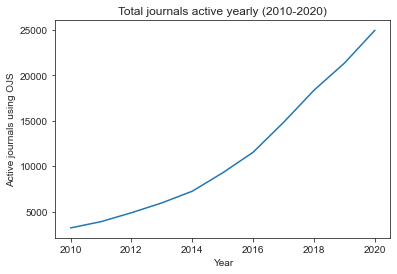

In [12]:
#Plot the total number of active journals using OJS by year (2010-2020)
%matplotlib inline
#Set style for sns
sns.set_style('white')
sns.set_style('ticks')

active_journal_growth = sns.lineplot(x = range(2010,2021), y = beaconGrowth.sum(axis=0))
active_journal_growth.set(xlabel = 'Year',
                          ylabel = 'Active journals using OJS',
                          title = 'Total journals active yearly (2010-2020)')
matplotlib.pyplot.show()

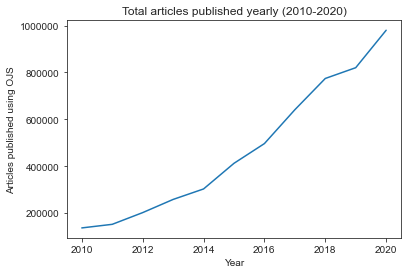

In [13]:
#Plot the number of new articles published each year (2010-2020)
%matplotlib inline

article_growth = sns.lineplot(x = range(2010,2021), y = beacon[record_cols[:-1]].sum().to_list())
article_growth.set(xlabel = 'Year',
                   ylabel = 'Articles published using OJS',
                   title = 'Total articles published yearly (2010-2020)')
article_growth.ticklabel_format(style='plain')
matplotlib.pyplot.show()

### Languages <a name=languages></a>

<a href='https://docs.google.com/document/d/103l90P0OuM0muOsmUYlnProG_Xo9yBR4IQ6INB21WaE/edit?usp=sharing'>This link</a> navigates to a Google doc with examples of journals using OJS to publish open access articles in **56 different languages**. <br>

#### Google's Compact Language Detector v3 (gcld3)

Import packages and create a defaultdict(list) to hold strings representing <a href='https://github.com/google/cld3'>gcld3 language classifications</a> for article abstracts published in each journal. <br> (*n*=20,420) 

In [14]:
import gcld3
import ijson
import json
import time 
from collections import Counter
from collections import defaultdict
#{journal issn: [list of predicted language codes for each article]}
issn_to_language = defaultdict(list)

Initialize <a href='https://github.com/google/cld3'>gcld3</a>:


In [15]:
identifier = gcld3.NNetLanguageIdentifier(min_num_bytes=0, max_num_bytes=1000)

Open a 15 GB .json file of selected metadata [title, description, subject, language]  for the most recent 100 journal articles published in 20,420 OJS contexts; <br> Pass the 'description' values to gcld3 to generate lists of predicted languages for each journal:

In [16]:
%%time

issn = ''
description_prefix = ''
journal_count = 0
article_count = 0

with open('Data/beacon_metadata.json', 'r') as f: #open json file, streamed as dict(dict(list(str)))
    #with open('Data/descriptions.txt', 'w') as outfile:
        
        for prefix, event, value in ijson.parse(f): #parse each json event iteratively
            
            if event == 'map_key': #if the event is a new dictionary
                if re.search('\d{4}-\d{4}', value): #and the value of the key is an issn
                    
                    issn = value #store the issn to use as a prefix in ijson.parse()
                    description_prefix = issn + '.' + 'description' + '.' + 'item' #store a 'description' prefix
                    journal_count += 1 #add to the journal count
                
            elif (prefix, event) == (description_prefix, 'string'): #if the json event is a 'description' string
            
                if len(value) > 10: #if the 'description' string is not arbitrary
                
                    #outfile.write(value + '\n') #save the description to a .txt file
                    article_count += 1 # add to the article count
                
                    language_result = identifier.FindLanguage(text=value)
                    if language_result.is_reliable: # if the language prediction is reliable
                    
                        issn_to_language[issn].append(language_result.language) 
                        #pass the 'description' string to gcld3 and store the predicted language code
                        #{journal issn: [list of predicted language codes for each article]}
                        del language_result
    
            else:
                continue

CPU times: user 1h 36min 24s, sys: 30.6 s, total: 1h 36min 55s
Wall time: 1h 37min 2s


Number of article abstracts:

In [17]:
article_count

8600880

Number of journals, indexed by issn:

In [18]:
len(issn_to_language)

20418

In [19]:
print(type(issn_to_language)) #defaultdict of defaultdict of lists
for k, v in issn_to_language.items():
    print(k) #issn for one journal
    print(v) #list of gcld3 language classifications for most recent 100 or fewer articles published in journal
    break

<class 'collections.defaultdict'>
2715-2502
['id', 'en', 'id', 'id', 'id', 'id', 'id', 'en', 'id', 'en', 'en', 'id', 'id', 'ms', 'id', 'en', 'id', 'en', 'id', 'id', 'en']


Store a list of gcld3 language codes corresponding to the 56 languages known to be supported by OJS:

In [20]:
known_langs = ['af', 'ar', 'bg', 'bg-Latn', 'bs', 'ca', 'cs', 'da', 'de', 'el', 'el-Latn', 'en', 'es', 'et', 'eu',
               'fa', 'fi', 'fr', 'gd', 'gl', 'hi', 'hi-Latn', 'hr', 'hu', 'hy', 'id', 'ig', 'is', 'it', 'ja',
               'ja-Latn', 'ka', 'kk', 'ko', 'lt', 'mk', 'ms', 'ne', 'nl', 'no', 'pl', 'pt', 'ro', 'ru', 'ru-Latn',
               'si', 'sk', 'sl', 'sr', 'sv', 'sw', 'ta', 'th', 'tr', 'uk', 'ur', 'uz', 'vi', 'zh', 'zh-Latn']

Create another dictionary of lists of article-level language classifications for each journal, filtered by inclusion in 'known_langs':

In [21]:
issn_language_lists = {}
for k, v in issn_to_language.items():
    issn_language_lists[k] = [lang for lang in v if lang in known_langs]

Create a dictionary that maps issn -> [(single most common language, prediction count)]:

In [22]:
top_languages = {}
for k, v in issn_language_lists.items():
    top_languages[k] = Counter(v).most_common(1)

Create a final dictionary mapping journal counts to their **primary** language, or the most common language identified in a given journal's article abstracts:

In [23]:
language_counts = defaultdict(int)
for k, v in top_languages.items():
    if v: #in case of empty lists
        language_counts[v[0][0]] += 1

Create a DataFrame called 'primaryLanguage' to represent ['language', 'count']:

In [24]:
#Store the language codes and their counts in a pd.Series
language_distribution = pd.Series(language_counts)
#Sort the language code Series by count
language_distribution.sort_values(ascending=False, inplace=True)
#Convert the Series to a DataFrame
primaryLangs = pd.DataFrame(language_distribution, columns=['count'], index=language_distribution.index)
primaryLangs.reset_index(inplace=True)
primaryLangs.rename(columns = {'index':'language'}, inplace=True)
#Total number of journals:
total = primaryLangs['count'].sum()
#Print n
print('Total: {} journals'.format(total))

Total: 20416 journals


In [25]:
primaryLangs.head(10)

,language,count
0,en,10165
1,id,4601
2,es,2423
3,pt,2062
4,uk,144
5,ru,133
6,de,114
7,fr,107
8,pl,69
9,ar,64


#### Bar plot of the 10 most common languages in which OJS users publish their articles  (*n*=20,416) <br>
Each bar represents the proportion of journals for which the specified language is their primary publishing language.

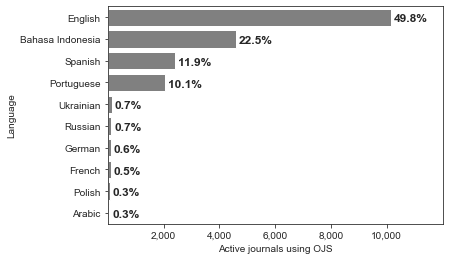

In [26]:
%matplotlib inline

fig, ax = matplotlib.pyplot.subplots()

sns.set_theme()
sns.set_style()
sns.set_style('whitegrid')
sns.set_color_codes()

lang = sns.barplot(x=primaryLangs['count'][:10],
                   y=['English', 'Bahasa Indonesia', 'Spanish', 'Portuguese', 'Ukrainian',
                      'Russian', 'German', 'French', 'Polish', 'Arabic'],
                   data=primaryLangs,
                   orient='h',
                   color='grey')

ax.set(xlim=(0, 12000),
       xlabel="Active journals using OJS",
       ylabel="Language")


matplotlib.pyplot.xticks([2000, 4000, 6000, 8000, 10000],
                         ['2,000', '4,000', '6,000', '8,000', '10,000'])

for p in lang.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.2
    percent = round(((p.get_width() / total) * 100), 1)
    value = '{}'.format(str(percent)+'%')
    lang.text(_x + 100, _y, value, ha='left', weight='bold')

fig.savefig('OJS_top10_langs.png', bbox_inches=('tight'))

#### Bar plot of multilingualism among journals using OJS  (*n*=20,228) <br>
Each bar represents the proportion of journals that published **5 or more articles in each of their publishing languages**.

In [27]:
multilingual = defaultdict(list)
for k, v in issn_to_language.items():
    for language in Counter(v).items():
        if language[1] >= 5: #If the the number of article abstracts tagged as a given language ('en') exceeds 5
            multilingual[k].append(language[0]) #Append the language (e.g.,'en') to a language list for the journal

In [28]:
multilingual_counts = defaultdict(int)
array_lengths = []

for k, v in multilingual.items():
    multiplier = len(v)
    array_lengths.append(multiplier)
    if multiplier >= 3:
        multilingual_counts['Multi- (3+ languages)'] += 1
    elif multiplier == 2:
        multilingual_counts['Bi- (2 languages)'] += 1
    elif multiplier == 1:
        multilingual_counts['Mono- (1 language)'] += 1
    else:
        continue
        
total = 0
for v in multilingual_counts.values():
    total += v
#Print n
print('Total: {} journals'.format(total))

#Print average length of language list per journal
print('Average number of languages per journal: {}'.format( np.array(array_lengths).mean() ))

Total: 20228 journals
Average number of languages per journal: 1.670011864741942


In [29]:
multilingual_dist = pd.Series(multilingual_counts)

multilingual_dist.sort_values(ascending=False, inplace=True)

multilingual_dist.index

Index(['Mono- (1 language)', 'Bi- (2 languages)', 'Multi- (3+ languages)'], dtype='object')

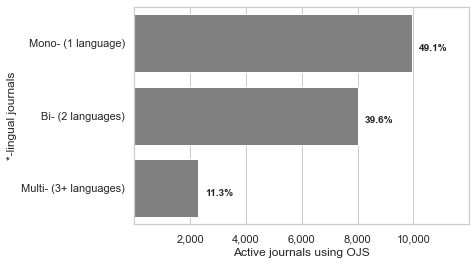

In [30]:
%matplotlib inline

fig, ax = matplotlib.pyplot.subplots()

mult = sns.barplot(y=multilingual_dist.index,
                   x=multilingual_dist.values,
                   orient='h',
                   color='grey')

ax.set(xlim=(0, 12000),
       xlabel="Active journals using OJS",
       ylabel="*-lingual journals")

matplotlib.pyplot.xticks([2000, 4000, 6000, 8000, 10000],
                         ['2,000', '4,000', '6,000', '8,000', '10,000'])

for p in mult.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.3
    percent = round(((p.get_width() / total) * 100), 1)
    value = '{}'.format(str(percent)+'%')
    mult.text(_x + 250, _y, value, ha='left', weight='bold')

fig.savefig('OJS_multilingual.png', bbox_inches=('tight'))

## Disciplines (In Progress) <a name=disciplines></a>

import pandas as pd
from fosc import load_model, vectorize
from fosc.config import config

model_id = 'mlp_l'
model = load_model(model_id)

df = pd.DataFrame(
    [
        { "id": "Information and Computer Science Example",
          "payload": "Automated classification of metadata of research" \
                     " data by their discipline(s) of research can be used" \
                     " in scientometric research, by repository service providers," \
                     " and in the context of research data aggregation services." \
                     " Openly available metadata of the DataCite index for research"\
                     " data were used to compile a large training and evaluation set" \
                     " comprised of 609,524 records, which is published alongside this" \
                     " paper. These data allow to reproducibly assess classification" \
                     " approaches, such as tree-based models and neural networks." \
                     " According to our experiments with 20 base classes (multi-label" \
                     " classification), multi-layer perceptron models perform best with" \
                     " a f1-macro score of 0.760 closely followed by Long Short-Term Memory" \
                     " models (f1-macro score of 0.755). A possible application of the" \
                     " trained classification models is the quantitative analysis of trends" \
                     " towards interdisciplinarity of digital scholarly output or the" \
                     " characterization of growth patterns of research data, stratified" \
                     " by discipline of research. Both applications perform at scale with" \
                     " the proposed models which are available for re-use."
         } 
    ]
)

vectorized = vectorize(df.payload, model_id).sort_indices()
preds = pd.DataFrame(model.predict(vectorized))
df = df.join(preds)
df

## World Bank income groups<a name="worldbank"></a>
Determine the number of active OJS journals by country, then group countries by income using World Bank GNI data*:
https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups <br>
*GNI data is updated as of FY22 but reflects 2020 data

Rename the beaconActive DataFrame's 'country_consolidated' variable as 'tld' (top-level domain):

In [31]:
beaconActive.rename(columns={'country_consolidated':'tld'}, inplace=True)

#### Preprocess the World Bank country and lending group dataset (12/2021):

In [32]:
wbGroups = pd.read_excel('data/wb_tlds.xlsx')

In [33]:
#Select only the country, income_group, and tld variables, and rename them accordingly:
wbGroups = wbGroups[['Economy',
                       'Income group',
                       'Domain']]
wbGroups.rename(columns={'Economy':'country','Income group':'income_group','Domain':'tld'}, inplace=True)

In [34]:
wbGroups.isnull().sum()

country         0
income_group    0
tld             1
dtype: int64

In [35]:
#There is one missing 'tld' value
wbGroups[wbGroups['tld'].isnull()]

,country,income_group,tld
141,Namibia,Upper middle income,NaN


In [36]:
#Namibia is missing! The top-level domain 'NA' read into pandas as NaN
#Change NaN to NA in the 'tld' column for both DataFrames
wbGroups['tld'] = np.where(wbGroups['tld'].isnull(), 'NA', wbGroups['tld'])
beaconActive['tld'] = np.where(beaconActive['oai_url'].str.contains('.na/'), 'NA', beaconActive['tld'])

In [37]:
#Filter the World Bank income class dataset to include only those countries that match beaconActive:
wbGroups = wbGroups[wbGroups['tld'].isin(beaconActive['tld'])].reset_index()
wbGroups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         139 non-null    int64 
 1   country       139 non-null    object
 2   income_group  139 non-null    object
 3   tld           139 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.5+ KB


In [38]:
#Check for duplicates in the 'tld' column 
wbGroups[wbGroups['tld'].duplicated()]

,index,country,income_group,tld
134,216,Kosovo,Upper middle income,AL


In [39]:
#Kosovo shares a top-level domain with Albania. But both Kosovo and Albania belong to the same income_group
#Merging on 'tld', so delete Kosovo for now
wbGroups.drop(index=134, inplace=True)

In [40]:
#Drop the index column
wbGroups.drop('index', axis=1, inplace=True)
for group in wbGroups['income_group'].unique():
    print(group)

Low income
Lower middle income
Upper middle income
High income
Unclassified


Change Venezuela's income classification from 'Unclassified' (2021) to its previous classification (2020):

In [41]:
wbGroups['income_group'] = np.where(wbGroups['income_group'].str.contains('Unclassified'),
                                    'Upper middle income',
                                    wbGroups['income_group'])

#### Merge the Beacon and World Bank datasets by Top-Level Domain

In [42]:
incomeGroups = beaconActive.merge(wbGroups, how='inner', on='tld')

In [43]:
#91 rows (25742 - 25651) contain empty 'tld' values, so those have been dropped
incomeGroups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25651 entries, 0 to 25650
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   oai_url       25651 non-null  object
 1   set_spec      25651 non-null  object
 2   context_name  25651 non-null  object
 3   issn          22832 non-null  object
 4   tld           25651 non-null  object
 5   issn_1        22832 non-null  object
 6   issn_2        8419 non-null   object
 7   journal_url   25651 non-null  object
 8   country       25651 non-null  object
 9   income_group  25651 non-null  object
dtypes: object(10)
memory usage: 2.2+ MB


In [44]:
incomeGroups.isnull().sum()

oai_url             0
set_spec            0
context_name        0
issn             2819
tld                 0
issn_1           2819
issn_2          17232
journal_url         0
country             0
income_group        0
dtype: int64

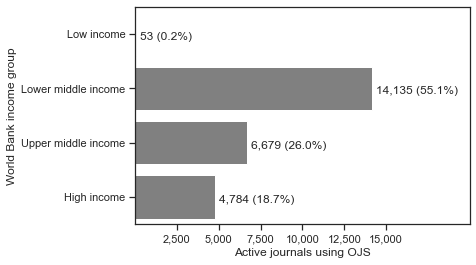

In [45]:
#Plot the distribution of OJS journals by World Bank income group
sns.set()
sns.set_style('ticks')
sns.set_color_codes()
inc = sns.countplot(y='income_group', 
                    order=['Low income',
                           'Lower middle income',
                           'Upper middle income',
                           'High income'],
                    data=incomeGroups,
                    color='grey')


matplotlib.pyplot.xlim(0,20000)

matplotlib.pyplot.xticks([2500, 5000, 7500, 10000, 12500, 15000],
                         ['2,500', '5,000', '7,500', '10,000', '12,500', '15,000'])

for p in inc.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height() - 0.3
    value = '{:,}'.format(p.get_width())
    percent = round(((p.get_width() / 25651) * 100), 1)
    value = value + ' ({})'.format(str(percent)+'%')
    inc.text(_x + 250, _y, value, ha='left')

inc.set(xlabel='Active journals using OJS', ylabel='World Bank income group')
inc.figure.savefig('OJS_income_groups.png', bbox_inches='tight')

## Index Overlap <a name="index"></a>